In [1]:
import os
import random
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
import keras
from keras import backend as K
from keras.applications import *
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import (VGG16, decode_predictions)
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import *
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# Loading Datasets
print('\n\n Loading Datasets. \n')

df = pd.read_csv('../dog_breed_datasets/labels.csv')
df.head()

n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(
        cv2.imread('../dog_breed_datasets/train/%s.jpg' % df['id'][i]),
        (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

dvi = int(X.shape[0]*0.9)
x_train = X[:dvi,:,:,:]
y_train = y[:dvi,:]
x_val = X[dvi:,:,:,:]
y_val = y[dvi:,:]

100%|██████████| 10222/10222 [00:25<00:00, 399.21it/s]


In [ ]:
# Fine-tune the model
print("\n\n Fine tune the model. \n")

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

inputs = Input((width, width, 3))
x = inputs
cnn_model = Xception(include_top=False, input_shape=(width, width, 3), weights='imagenet')
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='predictions')(x)
model = Model(inputs=inputs, outputs=x)

# for layer in model.layers[:114]:
#     layer.trainable = False


try:
    model.load_weights('Xception.h5')
    print('Load Xception.h5 successfully.')
except:
    model.load_weights('fc.h5', by_name=True)
    print('Fail to load Xception1.h5, load fc.h5 instead.')
          
lr = 0.0001
print("\n lr=" + str(lr) + " \n")
model.compile(
    optimizer=Nadam(lr=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=Trues),
#               metrics=['accuracy'])

batch_size = 16
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append((logs.get('loss'), logs.get("val_loss")))

history = LossHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath='Xception.h5', verbose=1, save_best_only=True)
# tensorboard = TensorBoard(batch_size=batch_size)
h2 = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size, 
    validation_data=val_datagen.flow(x_val, y_val, batch_size=batch_size), 
    validation_steps=len(x_val) / batch_size,
    epochs=10000,
    callbacks=[early_stopping, checkpointer])

np.savetxt("loss_history.csv", history_losses)

# model.save('Xception.h5','w')

Load Xception.h5 successfully.
Epoch 1/10000
575/574 [==============================] - 530s 922ms/step - loss: 0.1565 - acc: 0.9533 - val_loss: 0.3851 - val_acc: 0.8749
Epoch 2/10000
413/574 [====================>.........] - ETA: 2:21 - loss: 0.1460 - acc: 0.9608

In [5]:
# Compute the bottleneck feature

def get_features(MODEL, data=X):
    cnn_model = MODEL(
        include_top=False, input_shape=(width, width, 3), weights='imagenet')

    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=32, verbose=1)
    return features
print('Start computing Xception bottleneck feature: ')
features = get_features(Xception, X)


Start computing Xception: 
10222/10222 [==============================] - 159s 16ms/step


In [9]:
# Training models

inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='predictions')(x)
model = Model(inputs, x)
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=5, validation_split=0.1)

model.save('fc.h5','w')

Train on 9199 samples, validate on 1023 samples
Epoch 1/5
9199/9199 [==============================] - 0s 47us/step - loss: 2.7375 - acc: 0.5221 - val_loss: 1.3061 - val_acc: 0.7771
Epoch 2/5
9199/9199 [==============================] - 0s 18us/step - loss: 0.9867 - acc: 0.8011 - val_loss: 0.8017 - val_acc: 0.8201
Epoch 3/5
9199/9199 [==============================] - 0s 17us/step - loss: 0.6979 - acc: 0.8387 - val_loss: 0.6772 - val_acc: 0.8221
Epoch 4/5
9199/9199 [==============================] - 0s 18us/step - loss: 0.5833 - acc: 0.8542 - val_loss: 0.6128 - val_acc: 0.8348
Epoch 5/5
9199/9199 [==============================] - 0s 18us/step - loss: 0.5128 - acc: 0.8685 - val_loss: 0.5772 - val_acc: 0.8377


Text(0.5,0,u'epoch')

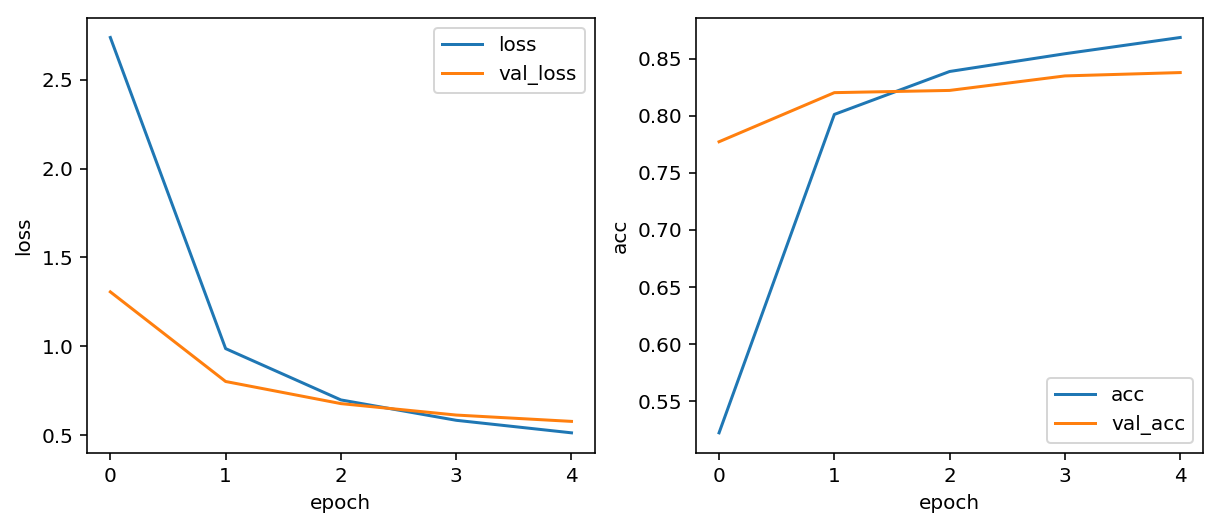

In [10]:
# Training preprocess visualization
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [5]:
# Fine-tune the model

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

inputs = Input((width, width, 3))
x = inputs
cnn_model = Xception(include_top=False, input_shape=(width, width, 3), weights='imagenet')
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='predictions')(x)
model = Model(inputs=inputs, outputs=x)

# for layer in model.layers[:114]:
#     layer.trainable = False


try:
    model.load_weights('Xception1.h5')
    print('Load Xception1.h5 successfully.')
except:
    model.load_weights('fc.h5', by_name=True)
    print('Fail to load Xception1.h5, load fc.h5 instead.')
          
model.compile(optimizer=Nadam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True, decay=0.0023),
#               metrics=['accuracy'])

batch_size = 16
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
h2 = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size, 
    validation_data=val_datagen.flow(x_val, y_val, batch_size=batch_size), 
    validation_steps=len(x_val) / batch_size,
    epochs=5,
    callbacks=[early_stopping])


model.save('Xception.h5','w')

Fail to load Xception1.h5, load fc.h5 instead.
Epoch 1/5
  1/574 [..............................] - ETA: 1:03:59 - loss: 0.9594 - acc: 0.6250

ResourceExhaustedError: OOM when allocating tensor with shape[16,10,10,2048]
	 [[Node: xception_1/block14_sepconv2/separable_conv2d = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](xception_1/block14_sepconv2/separable_conv2d/depthwise, block14_sepconv2_1/pointwise_kernel/read)]]
	 [[Node: loss_1/mul/_4809 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_20936_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'xception_1/block14_sepconv2/separable_conv2d', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-359cb3f699bd>", line 18, in <module>
    x = cnn_model(x)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 1221, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3284, in separable_conv2d
    data_format=tf_data_format)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_impl.py", line 497, in separable_conv2d
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,10,10,2048]
	 [[Node: xception_1/block14_sepconv2/separable_conv2d = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](xception_1/block14_sepconv2/separable_conv2d/depthwise, block14_sepconv2_1/pointwise_kernel/read)]]
	 [[Node: loss_1/mul/_4809 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_20936_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h2.history['acc'])
plt.plot(h2.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

NameError: name 'h2' is not defined